In [4]:
install.packages("tseries")
install.packages("forecast")
install.packages("scales")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fracdiff’, ‘lmtest’, ‘urca’, ‘RcppArmadillo’




In [1]:
library("ggplot2")
library("tseries")
library("forecast")
library("base")
library("scales")

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



# Análisis de series de tiempo utilizando modelos $ARIMA$

En el presente capítulo se realizará el análisis para la serie de tiempo cantidad de viajes realizados en la Ciudad de México utilizando las bicicletas del programa de gobierno EcoBici. Los datos se encuentran presentes en cada una de las bases de datos, estas pueden obtenerse descargándolas desde la página oficial del programa [Ecobici](https://www.ecobici.cdmx.gob.mx/es/informacion-del-servicio/open-data).

Las bases de datos son mensuales y se cuenta con información desde febrero de $2010$ hasta mayo $2020$, por lo que se tiene un total de $124$ observaciones, las cuales representan la cantidad de viajes realizados en el respectivo mes y año.

### Lectura y preparación de datos

In [82]:
data <- read.csv("EcoBici.csv", stringsAsFactors = FALSE) ### No se desea que el anio sea un factor, lo queremos como caracter
data <- data[c(43:nrow(data)),]
data$Anio[c(78:82)] <- gsub("2010", "2020", data$Anio[c(78:82)])

In [83]:
head(data)

,Anio,Viajes
,<chr>,<int>
43,2013-08,615971
44,2013-09,574001
45,2013-10,713401
46,2013-11,656292
47,2013-12,580750
48,2014-01,664949


Se prefiere trabajar con letras minúsculas, por lo que se cambiará la primera letra del nombre de cada columna a minúscula, además la primer columna `anio` no hace referencia al año únicamente, sino también al mes correspondiente, por lo que hará el cambio del nombre a `fecha`.

In [84]:
colnames(data) <- c("fecha", "viajes")

### Estructura de datos

In [85]:
summary(data)

    fecha               viajes      
 Length:82          Min.   :153147  
 Class :character   1st Qu.:667276  
 Mode  :character   Median :709388  
                    Mean   :707478  
                    3rd Qu.:783478  
                    Max.   :878358  

Nótese que la fecha aparece como  `character`, cuando en realidad debería ser un objeto `date` de `R`, a continuación se realizará el cambio correspondiente, para ello se supondrá que todos los meses tienen $28$ días, pues la función `as.Date`, presenta dificultades al tratar de identificar un mes que en tiene $28$ días (febrero) al momento de agregarle $30$ días o más.

In [86]:
data$fecha <- as.Date(paste0(data$fecha,"-28"))

In [87]:
data[which.min(data$viajes),]

,fecha,viajes
,<date>,<int>
124,2020-05-28,153147


In [88]:
data[which.max(data$viajes),]

,fecha,viajes
,<date>,<int>
86,2017-03-28,878358


* La cantidad menor de viajes fue de $1,057$, lo cual se obtuvo al inicio del programa, esto es, en febrero de $2010$.
* La cantidad mayor de viajes fue de $878,358$, obtenida el $2012-03$, esto es, en marzo de $2017$.

### Visualización de la serie de tiempo

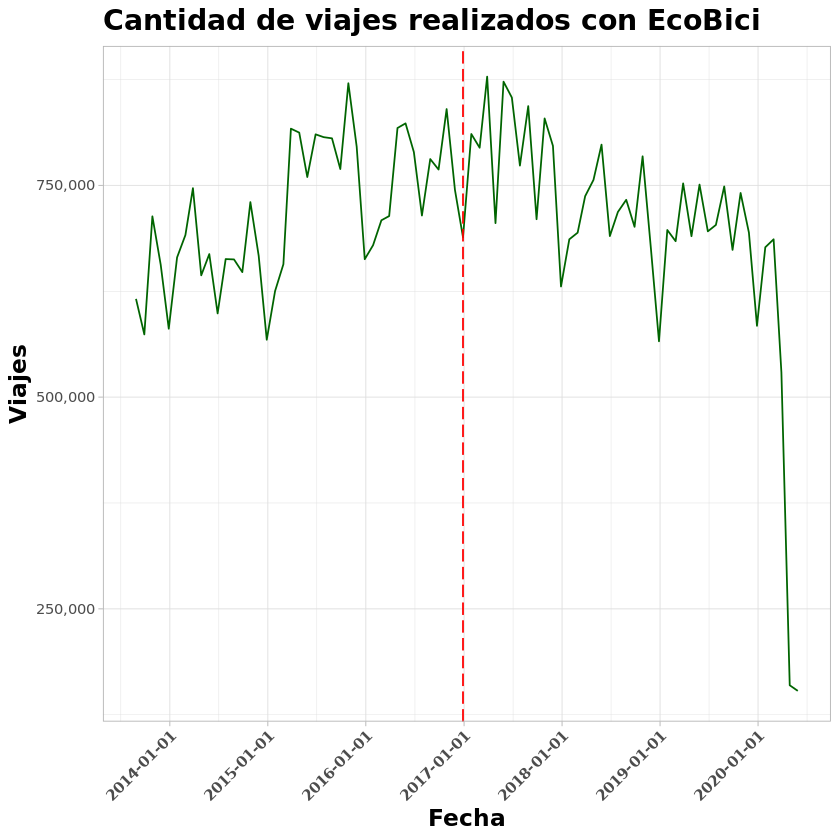

In [89]:
ggplot(data, aes(x = fecha, y = viajes)) + 
    theme_light() +
    geom_line(color = "darkgreen") + 
    scale_x_date(breaks='1 years') + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"), 
          plot.title = element_text(size = 17, face = "bold"), 
          axis.title = element_text(size=14, face="bold")) + 
    scale_y_continuous(labels = comma) +
    geom_vline(xintercept = as.numeric(data$fecha[41]),
                linetype = 5, colour="red") + 
    xlab("Fecha") + 
    ylab("Viajes") +
    ggtitle("Cantidad de viajes realizados con EcoBici")

Al parecer la serie de tiempo comienza a estabilizarse a partir de junio de $2013$, esta fecha está marcada con una franja roja en el gráfico anterior.

### Definir grado de diferenciación $(d)$ y estabbilización de la varianza

Se utilizará la transformación $log$ para la estabilización de la varianza

In [90]:
lamb <- BoxCox.lambda(data$viajes)
lamb

[1] -0.2297004

Notemos que la transformación sugerida por la metodología de $Box-Cox$ es muy cercana a $0.5$, valor que equivale a la raíz cuadrada.

In [91]:
tran_box <- function(xt,lamb){
  if (lamb == 0) {
    xt_box <- log(xt)
  } else {
    xt_box <- (xt^lamb - 1)/lamb
  }
}

In [92]:
data$box_cox <- tran_box(data$viajes, 0.5)

Visualizemos la serie de tiempo tras el proceso de estabilización de la varianza

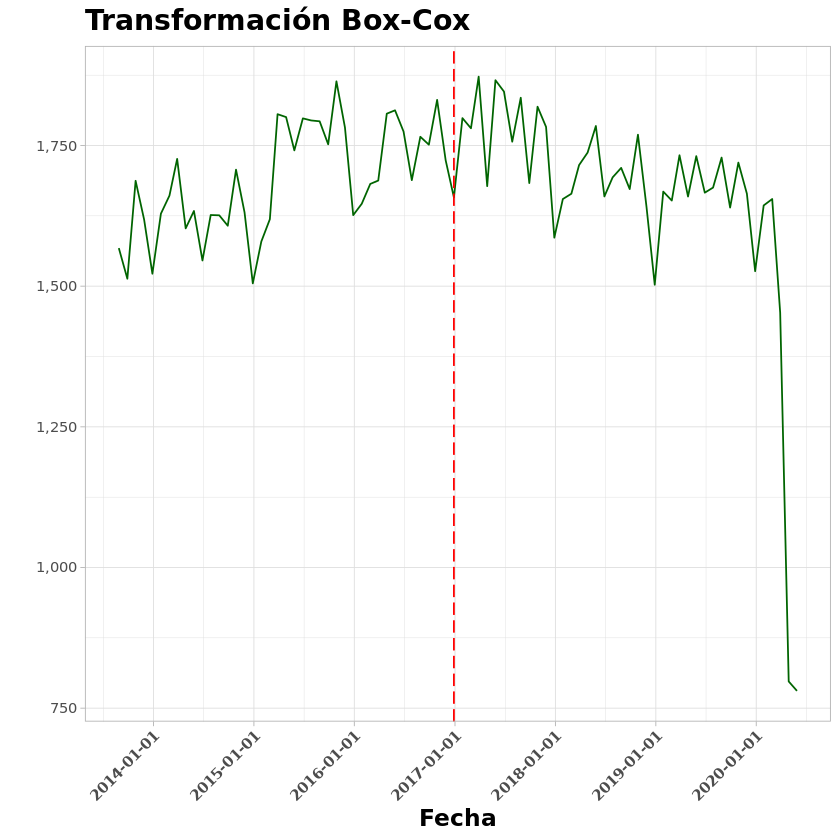

In [93]:
ggplot(data, aes(x = fecha, y = box_cox)) + 
    theme_light() +
    geom_line(color = "darkgreen") + 
    scale_x_date(breaks='1 years') + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"), 
          plot.title = element_text(size = 17, face = "bold"), 
          axis.title = element_text(size=14, face="bold")) + 
    scale_y_continuous(labels = comma) +
    geom_vline(xintercept = as.numeric(data$fecha[41]),
                linetype = 5, colour="red") + 
    xlab("Fecha") + 
    ylab("") +
    ggtitle("Transformación Box-Cox")

Sigue ocurriendo el mismo fenónemo relacionado a la estabilización a la fecha de junio de $2013$.

Visualizemos la serie de tiempo con una diferencia $(d = 1)$

In [94]:
st_d1 <- diff(data$box_cox, 1)
data_d1 <- data.frame(fecha = data$fecha[-1], st_d1 = st_d1)

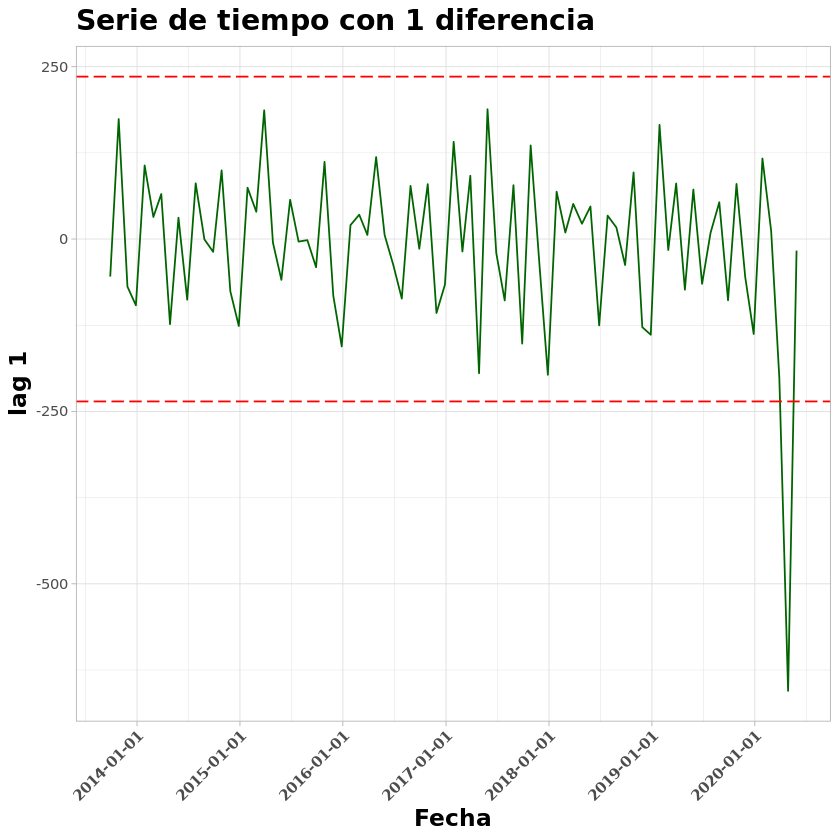

In [95]:
ggplot(data_d1, aes(x = fecha, y = st_d1)) + 
    theme_light() +
    geom_line(color = "darkgreen") + 
    scale_x_date(breaks='1 years') + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"), 
          plot.title = element_text(size = 17, face = "bold"), 
          axis.title = element_text(size=14, face="bold")) + 
    scale_y_continuous(labels = comma) +
    geom_hline(yintercept = 2*sqrt(var(data_d1$st_d1)),
                linetype = 5, colour="red") + 
    geom_hline(yintercept = -2*sqrt(var(data_d1$st_d1)),
                linetype = 5, colour="red") + 
    xlab("Fecha") + 
    ylab("lag 1") +
    ggtitle("Serie de tiempo con 1 diferencia")

Nótese que hay $3$ picos muy altos (en base a la desviación estándar de los datos), sin embargo, dada la cantidad de observaciones $(123)$ no es muy alarmante.

In [96]:
adf.test(data_d1$st_d1, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  data_d1$st_d1
Dickey-Fuller = -2.4175, Lag order = 4, p-value = 0.4048
alternative hypothesis: stationary


Se realiza la prueba estadística de **Dickey-Fuller** para tener evidencia estadística al utilizar $1$ sola diferencia para estacionalizar la serie de tiempo. Se obtiene $p-value = 0.01$, lo cual (bajo el nivel de significancia $(\alpha = 0.05)$ se rechaza la hipótesis nula, esta es, la serie de tiempo no es estacionaria y se prosigue con el análisis.

El problema se sigue presentando aún a pesar de agregar 2 diferencias a la serie de tiempo, es por ello que se decide trabajar con la serie de tiempo con $1$ sola diferencia, es decir, con un grado de diferenciación.

### Función de autocorrelación y función de autocorrelación

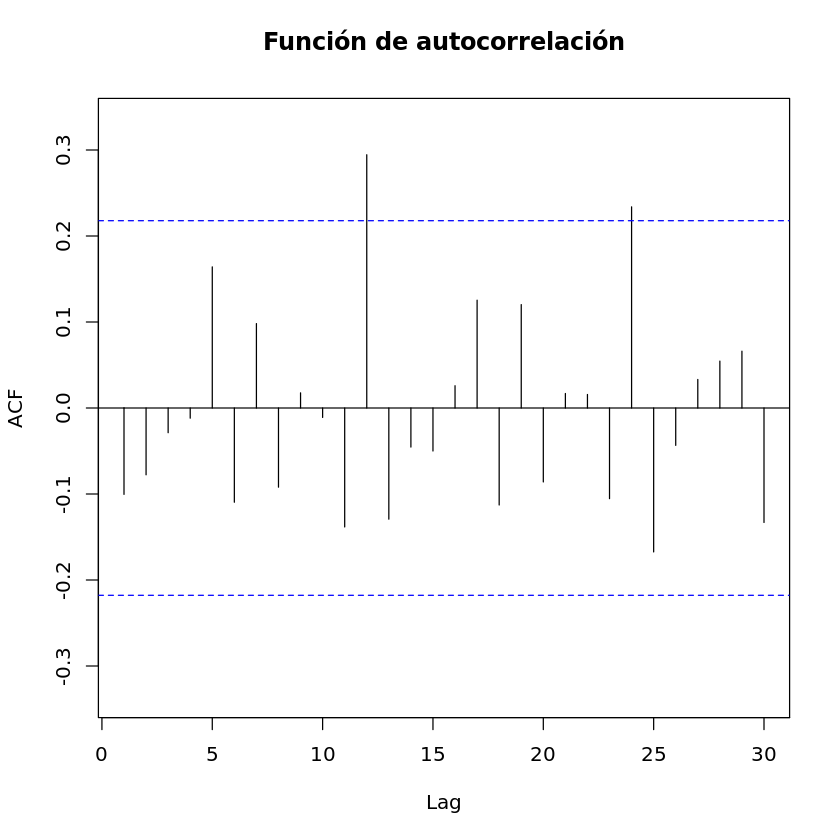

In [99]:
Acf(data_d1$st_d1, main='Función de autocorrelación', lag.max = 30)

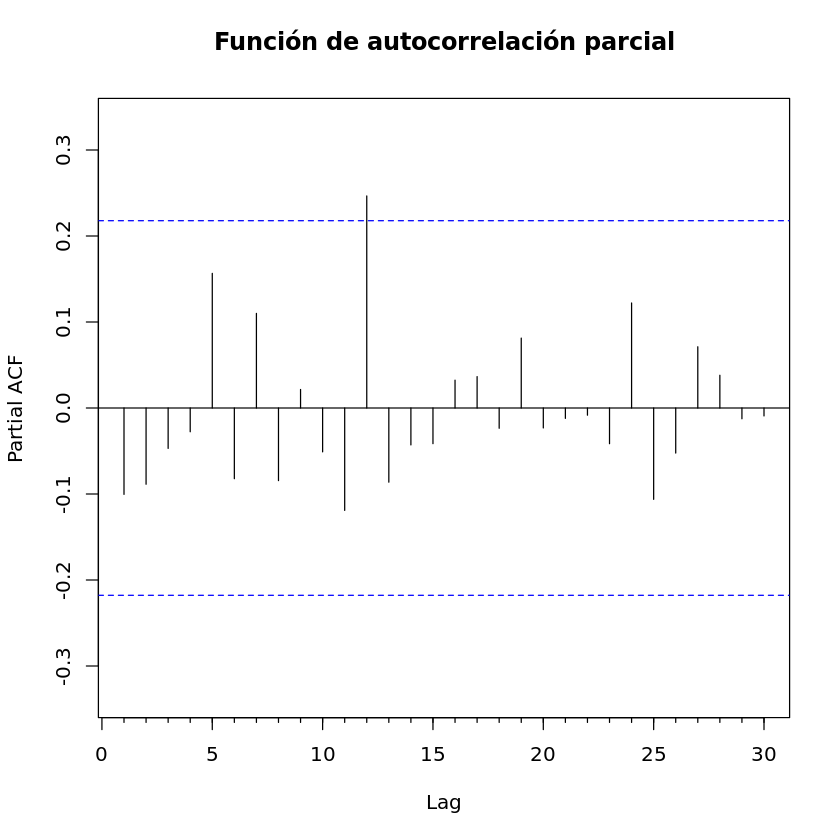

In [100]:
Pacf(data_d1$st_d1, main='Función de autocorrelación parcial', lag.max = 30)

La función de autocorrelación y la función de autocorrelaciónparcial sugieren que los grados del polinomio autorregresivo y de promedios móviles deben ser $1$ para ambos, pues es el único valor que sale por fuera de las franjas de significancia (la prime línea correponde al Lag $0$).

### Modelos

El modelo a estimar es es siguiente:


* `mod_1` = $ARIMA(p = 1, d = 1, q = 0), (P = 0, D = 1, Q = 1)$




In [119]:
mod_1 <- Arima(y = data_d1$st_d1,
               order = c(1, 1, 0), 
               seasonal = list(order = c(0, 1, 1), period = 12), lambda = lamb, biasadj = TRUE)

Los intervalos de confianza para los parámetros (coeficientes de los polinomios) estimados para `mod_1` son:

In [112]:
confint(mod_1)

,2.5 %,97.5 %
ar1,-0.9908372,-0.6682068
sma1,-1.2313365,-0.1347710


Nótese que los intervalos de confianza para los parámetros estimados no contienen el $0$ o son cercanos a él, esto es una propiedad importante para el análisis, pues en caso de que lo contuviera alguno de ellos, entonces existiría evidencia estadística para eliminar el polinomio respectivo.

### Pronósticos

Para la evaluación del modelo se hará el pronóstico de enero hasta mayo del $2020$, para ello se entrenará el modelo con todas las observaciones excepto aquellas que hagan mención al $2020$.

In [121]:
data_fc <- data_d1[1:76,]

In [123]:
mod_1 <- Arima(y = data_fc$st_d1,
               order = c(1, 1, 0), 
               seasonal = list(order = c(0, 1, 1), period = 12), lambda = lamb, biasadj = TRUE)

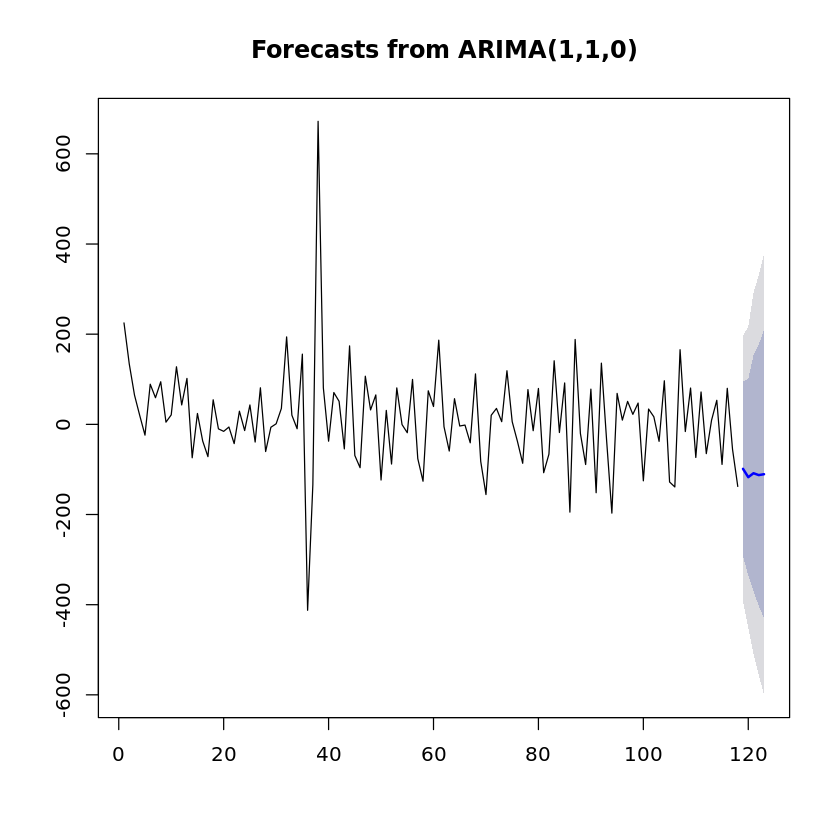

In [125]:
fcast <- forecast(mod_1_fc, h=5)
plot(fcast)

In [28]:
last_date <- data$fecha %>% 
                tail(5)
forecast_ts <- data.frame(fecha = rep(last_date, 2),
                          value = c(data$viajes %>% tail(5), fcast$mean),
                          Up_CI = c(data$viajes %>% tail(5), fcast$upper %>% .[,2]),
                          Lo_CI = c(data$viajes %>% tail(5), fcast$lower %>% .[,2]),
                          tipo = c(rep("Original", 5), rep("Pronostico", 5)))
forecast_ts

fecha,value,Up_CI,Lo_CI,tipo
<date>,<dbl>,<dbl>,<dbl>,<fct>
2010-01-28,676908.000,676908.00,676908.00,Original
2010-02-28,686327.000,686327.00,686327.00,Original
2010-03-28,529077.000,529077.00,529077.00,Original
2010-04-28,159780.000,159780.00,159780.00,Original
2010-05-28,153147.000,153147.00,153147.00,Original
2010-01-28,3344.249,9877.88,-38443.24,Pronostico
2010-02-28,3941.172,11964.03,-50415.58,Pronostico
2010-03-28,7627.216,21676.48,-64332.20,Pronostico
2010-04-28,9763.096,27765.27,-76827.71,Pronostico


In [29]:
geom_ribbon(aes(ymin=data$lower, ymax=data$upper), linetype=2, alpha=0.1)

mapping: ymin = ~data$lower, ymax = ~data$upper 
geom_ribbon: na.rm = FALSE, orientation = NA, outline.type = both
stat_identity: na.rm = FALSE
position_identity 

In [30]:
rep(last_date, 2)

[1] "2010-01-28" "2010-02-28" "2010-03-28" "2010-04-28" "2010-05-28"
 [6] "2010-01-28" "2010-02-28" "2010-03-28" "2010-04-28" "2010-05-28"

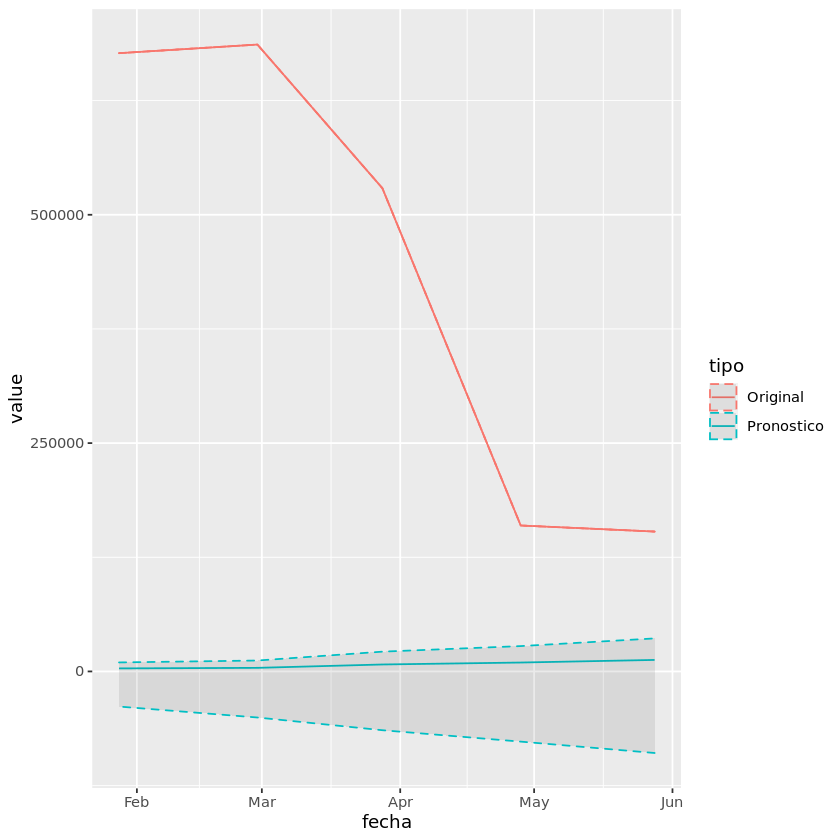

In [31]:
ggplot(forecast_ts, aes(x = fecha, y = value, color = tipo)) + 
    geom_line() + 
    geom_ribbon(aes(ymin = Lo_CI, ymax = Up_CI), linetype=2, alpha=0.1)

In [32]:
model <- auto.arima(data$viajes)
summary(model)

Series: data$viajes 
ARIMA(1,1,2) 

Coefficients:
          ar1     ma1      ma2
      -0.5956  0.4266  -0.3403
s.e.   0.1762  0.1804   0.0951

sigma^2 estimated as 6.426e+09:  log likelihood=-1562.04
AIC=3132.09   AICc=3132.43   BIC=3143.34

Training set error measures:
                   ME     RMSE     MAE        MPE     MAPE      MASE
Training set 2768.571 78857.14 54541.5 0.02953058 14.71268 0.9474949
                    ACF1
Training set 0.002306459


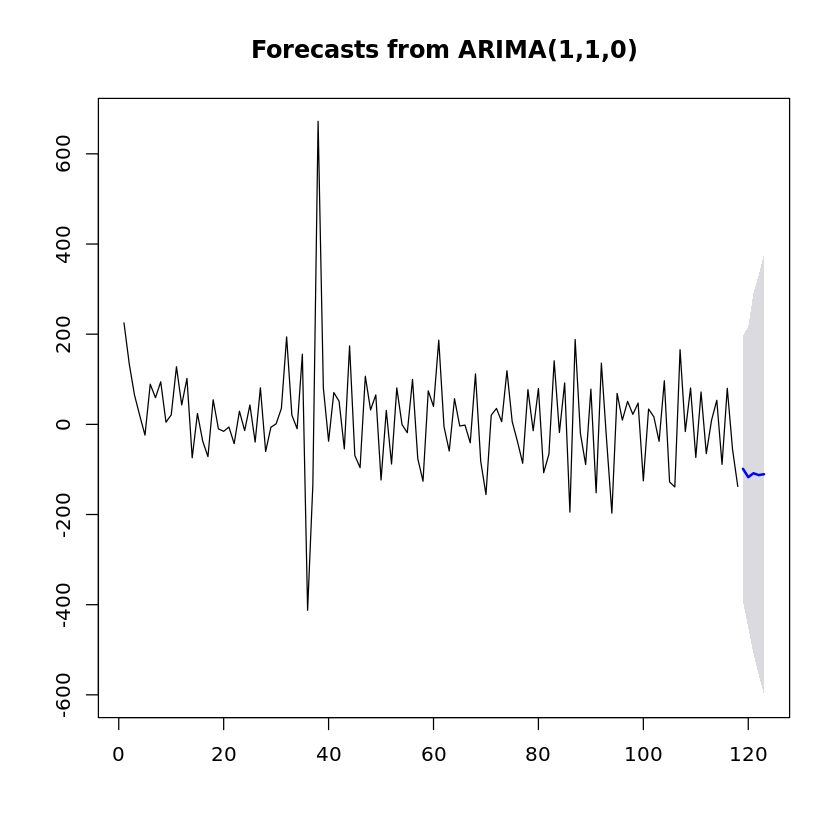

In [33]:
fc <- forecast(mod_1_fc, h = 5, level=95)

fvar <- ((BoxCox(fc$upper, 0.5) -
    BoxCox(fc$lower, 0.5))/qnorm(0.975)/2)^2
plot(fc)
fc$mean <- fc$mean * (1 + 0.5*fvar)
lines(fc$mean,col='red')